In [1]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(ggplot2)
library(ggpubr)

In [3]:
df = read.csv("/data/work/MASSON/Masson_20241021.csv")
df = df[!is.na(df$Masson),]
df$Group = factor(df$Group, levels=c("E16.5", "E17.5", "E18.5", "P0", "P5", "Adult"))
head(df)

,Group,Wound,Masson
,<fct>,<chr>,<dbl>
1,E16.5,Wound,46.97526
2,E17.5,Wound,49.64039
3,E18.5,Wound,55.17101
4,P5,Wound,53.79460
5,Adult,Wound,67.30878
6,E16.5,Wound,46.40390


In [4]:
# 复制 P0 Control 行并分配到 E16.5, E17.5, E18.5 组
df_control <- df %>% filter(Group == "P0")
df_control <- bind_rows(df_control,df_control, df_control)
df_control <- df_control %>% mutate(Group = factor(rep(c("E16.5", "E17.5", "E18.5"),each = 3)))
df_combined <- bind_rows(filter(df, Group != "P0"), df_control)

In [5]:
df_summary <- df_combined %>%
  group_by(Group, Wound) %>%
  summarise(CVF = mean(Masson), SE = sd(Masson) / sqrt(n()))
df_summary

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


Group,Wound,CVF,SE
<fct>,<chr>,<dbl>,<dbl>
E16.5,Control,46.08128,1.9082936
E16.5,Periwound,48.26719,0.4736775
E16.5,Wound,47.75140,1.0745506
E17.5,Control,46.08128,1.9082936
E17.5,Periwound,52.91572,1.8053102
E17.5,Wound,54.16023,2.3260181
E18.5,Control,46.08128,1.9082936
E18.5,Periwound,46.46061,1.0728367
E18.5,Wound,52.59506,3.6220399


In [20]:
# 绘制柱状图
p <- ggplot(df_summary, aes(x = Group, y = CVF, color = Wound)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), width = 0.75, fill='white')+
  geom_errorbar(aes(ymin = CVF - SE, ymax = CVF + SE), 
                position = position_dodge(width = 0.8), width = 0.25) +
  geom_point(data = df_combined, aes(x = Group, y = Masson, fill = Wound), 
             position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.8), size = 2) +
  labs(title = "", x = "", y = "Collagen volume fraction(%)")  +
  scale_y_continuous(limits = c(0, 90)) + 
  scale_color_manual(values = c("black","#159DC0", "#EE4143"))# +
  # scale_pattern_manual(values = c("none", "stripe")) +
  geom_blank()


science_theme <- theme(
  panel.background = element_blank(),  # 去除背景
  panel.grid.major = element_blank(),  # 去除主网格线
  panel.grid.minor = element_blank(),  # 去除次网格线
  axis.line = element_line(color = "black"),  # 坐标轴线颜色
  axis.ticks = element_line(color = "black"),  # 坐标轴刻度线颜色
  axis.text = element_text(size = 12, color = "black"),  # 坐标轴文字大小和颜色
  axis.title = element_text(size = 14, face = "bold"),  # 坐标轴标题大小和加粗
  plot.title = element_text(size = 16, face = "bold", hjust = 0.5),  # 图标题大小、加粗和居中
  legend.position = "none"  # 去除图例
)

p <- p + science_theme

geom_blank: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

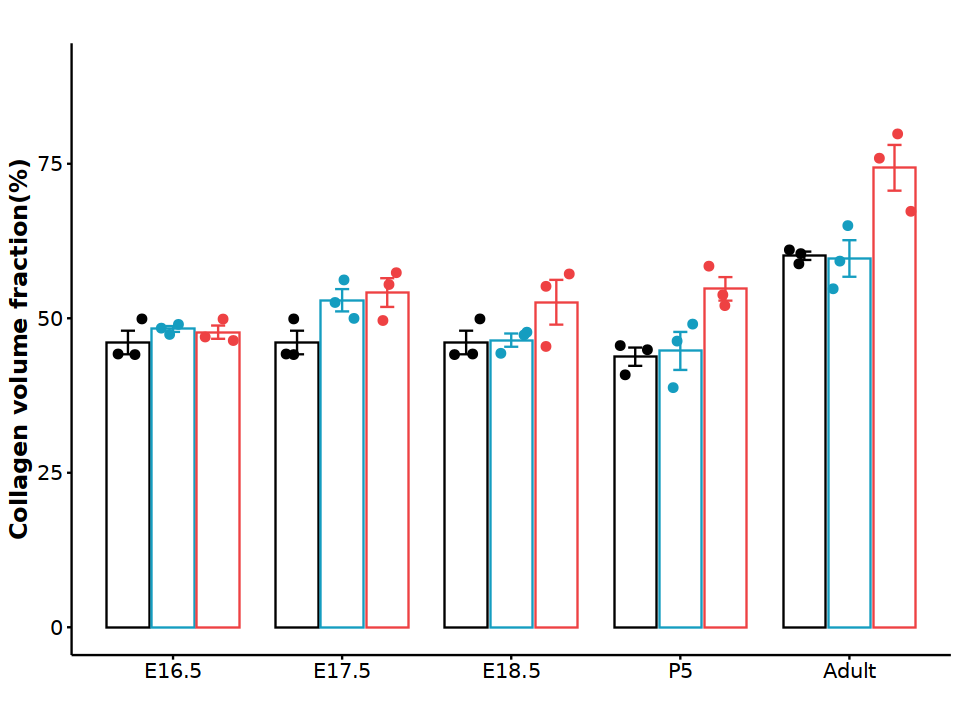

In [21]:
options(repr.plot.width=8, repr.plot.height=6)
p

In [22]:
ggsave("MASSON_bar_241021.pdf", width=7, height=5)

In [9]:
install.packages("agricolae")

Updating HTML index of packages in '.Library'

Warning message in file.create(f.tg):
“cannot create file '/opt/conda/lib/R/doc/html/packages.html', reason 'Permission denied'”
Warning message in make.packages.html(.Library):
“cannot update HTML package index”


In [10]:
library(agricolae)

In [13]:
fit = aov(Masson ~ Wound * Group, data=df)

In [14]:
result_O = HSD.test(fit,c("Wound", "Group"), group = T)
print(result_O)

$statistics
   MSerror Df     Mean       CV      MSD
  15.25346 26 52.74031 7.405279 11.58852

$parameters
   test      name.t ntr StudentizedRange alpha
  Tukey Wound:Group  13         5.139305  0.05

$means
                  Masson       std r      se      Min      Max      Q25
Control:Adult   60.11262 1.1707394 3 2.25488 58.80711 61.06927 59.63430
Control:P0      46.08128 3.3052614 3 2.25488 44.12668 49.89749 44.17317
Control:P5      43.78232 2.5593752 3 2.25488 40.85283 45.58469 42.88113
Periwound:Adult 59.67440 5.1221175 3 2.25488 54.77734 64.99524 57.01398
Periwound:E16.5 48.26719 0.8204335 3 2.25488 47.38712 49.01090 47.89533
Periwound:E17.5 52.91572 3.1268889 3 2.25488 49.98294 56.20599 51.27059
Periwound:E18.5 46.46061 1.8582076 3 2.25488 44.33072 47.75052 45.81566
Periwound:P5    44.71547 5.3229454 3 2.25488 38.77754 49.05902 42.54369
Wound:Adult     74.34834 6.4056171 3 2.25488 67.30878 79.83418 71.60541
Wound:E16.5     47.75140 1.8611762 3 2.25488 46.40390 49.87503 46.68958